# Loading and Verification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
df = pd.read_csv('sales_data.csv')

In [2]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11631 entries, 0 to 11630
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     11631 non-null  object
 1   rating                    11582 non-null  object
 2   number_of_reviews         11582 non-null  object
 3   bought_in_last_month      10702 non-null  object
 4   current/discounted_price  8519 non-null   object
 5   price_on_variant          11631 non-null  object
 6   listed_price              11631 non-null  object
 7   is_best_seller            11631 non-null  object
 8   is_sponsored              11631 non-null  object
 9   is_couponed               11631 non-null  object
 10  buy_box_availability      7834 non-null   object
 11  delivery_details          8524 non-null   object
 12  sustainability_badges     1156 non-null   object
 13  image_url                 11631 non-null  object
 14  product_url           

,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
count,11631,11582,11582,10702,8519,11631,11631,11631,11631,11631,7834,8524,1156,11631,10957,11630
unique,8493,30,4295,49,2481,3364,877,4,2,33,1,197,16,7752,10957,406
top,"Duracell Coppertop 9V Battery, 6 Count (Pack o...",4.7 out of 5 stars,8,100+ bought in past month,179.99,basic variant price: nan,No Discount,No Badge,Organic,No Coupon,Add to cart,"Delivery Mon, Sep 1",Small Business,https://m.media-amazon.com/images/I/51Xr76m2WL...,/PowerA-Stereo-Headset-Nintendo-Gaming-Console...,2025-08-21 11:22:39
freq,244,1778,232,1515,263,5482,8306,11226,9354,11018,7834,5931,420,324,1,33


In [3]:
df.listed_price.value_counts()

,count
listed_price,
No Discount,8306
$79.99,224
$29.99,104
$49.99,89
$99.99,70
...,...
"$3,199.99",1
$461.00,1
$41.95,1


In [4]:
df.isnull().sum()

,0
title,0
rating,49
number_of_reviews,49
bought_in_last_month,929
current/discounted_price,3112
price_on_variant,0
listed_price,0
is_best_seller,0
is_sponsored,0
is_couponed,0


# Cleaning

In [5]:
def cleaned_up_code(rows_of_data, debug=False):
  df = rows_of_data.copy()
  fill_zero_cols = ['number_of_reviews', 'bought_in_last_month']
  fill_blank_cols = ['product_url', 'delivery_details', 'buy_box_availability']
  fill_unknown_cols = ['sustainability_badges']

  for col in fill_zero_cols:
    if col in df.columns:
      df[col] = df[col].fillna(0)
  for col in fill_unknown_cols:
    if col in df.columns:
      df[col] = df[col].fillna('Unknown').astype(str)
  for col in fill_blank_cols:
    if col in df.columns:
      df[col] = df[col].fillna('').astype(str)
  if 'rating' in df.columns:
        df['rating_numeric'] = pd.to_numeric(
            df['rating'].astype(str).str.extract(r'(\d+\.\d+)')[0], errors='coerce'
        )
  if 'current/discounted_price' in df.columns:
      df['current/discounted_price'] = pd.to_numeric(
          df['current/discounted_price'], errors='coerce'
      )

  def extract_numeric_column(col, remove_text=None, special_cases=None):
    col_str = col.astype(str)
    def converter(x):
        val = str(x).lower().strip()
        if special_cases:
            for case in special_cases:
                if case.lower() in val:
                    return np.nan
        if remove_text:
            for txt in remove_text:
                val = val.replace(str(txt).lower(), '')
        val = re.sub(r'basic variant price[:\s]*', '', val)
        val = val.replace(',', '').strip()
        match = re.search(r'(\d*\.?\d+)', val)
        if match:
            number = float(match.group(1))
            if 'k' in val:
                number *= 1000
            return number
        try:
            return float(x)
        except:
            return np.nan
    return col_str.apply(converter)

  if 'bought_in_last_month' in df.columns:
    df['bought_in_last_month_clean'] = extract_numeric_column(
            df['bought_in_last_month'], remove_text=['+']
        ).fillna(0)
  if 'price_on_variant' in df.columns:
    df['price_on_variant_clean'] = extract_numeric_column(
            df['price_on_variant'], remove_text=['$']
        )
  if 'listed_price' in df.columns:
    df['listed_price_clean'] = extract_numeric_column(
            df['listed_price'], remove_text=['$'], special_cases=['No Discount']
        )
  if debug:
      print("\n[DEBUG] Sample of cleaned numeric columns:")
      numeric_cols = ['bought_in_last_month_clean', 'price_on_variant_clean', 'listed_price_clean']
      for col in numeric_cols:
          if col in df.columns:
              print(col, df[col].head())

  drop_cols = ['bought_in_last_month', 'price_on_variant', 'listed_price', 'rating']
  drop_cols = [col for col in drop_cols if col in df.columns]
  df.drop(columns=drop_cols, inplace=True)

  numeric_cols = ['number_of_reviews', 'bought_in_last_month_clean',
                    'listed_price_clean', 'price_on_variant_clean',
                    'rating_numeric', 'current/discounted_price']
  for col in numeric_cols:
    if col in df.columns:
      df[col] = pd.to_numeric(df[col], errors='coerce')

  agg_dict = {}
  numeric_agg_map = {
      'rating_numeric': 'mean',
      'number_of_reviews': 'sum',
      'bought_in_last_month_clean': 'sum',
      'listed_price_clean': lambda x: x.mean() if len(x.dropna()) > 0 else np.nan,
      'price_on_variant_clean': 'mean',
      'current/discounted_price': 'mean'
  }
  for col, agg in numeric_agg_map.items():
        if col in df.columns:
            agg_dict[col] = agg

  string_cols = ['buy_box_availability', 'delivery_details', 'sustainability_badges', 'product_url']
  for col in string_cols:
      if col in df.columns:
          agg_dict[col] = 'first'

  if 'title' in df.columns:
      grouped_df = df.groupby('title', dropna=False).agg(agg_dict).reset_index()
      for col in string_cols:
          if col in grouped_df.columns:
              grouped_df[col] = grouped_df[col].fillna('Unknown').astype(str)
  else:
      grouped_df = df.copy()

  if debug:
      print("\n[DEBUG] Sample of cleaned numeric columns:")
      for col in numeric_cols:
          if col in grouped_df.columns:
              print(col, grouped_df[col].head())

  return grouped_df

In [6]:
cleaned_df = cleaned_up_code(df, debug=True)
print(cleaned_df.head())


[DEBUG] Sample of cleaned numeric columns:
bought_in_last_month_clean 0      300.0
1     6000.0
2     2000.0
3    10000.0
4    10000.0
Name: bought_in_last_month_clean, dtype: float64
price_on_variant_clean 0      2.40
1       NaN
2       NaN
3    162.24
4     72.74
Name: price_on_variant_clean, dtype: float64
listed_price_clean 0    159.00
1     15.99
2    349.00
3       NaN
4       NaN
Name: listed_price_clean, dtype: float64

[DEBUG] Sample of cleaned numeric columns:
number_of_reviews 0    136.0
1      0.0
2    141.0
3      0.0
4      0.0
Name: number_of_reviews, dtype: float64
bought_in_last_month_clean 0    200.0
1    500.0
2     50.0
3    300.0
4    500.0
Name: bought_in_last_month_clean, dtype: float64
listed_price_clean 0       NaN
1       NaN
2    729.00
3     48.99
4     55.99
Name: listed_price_clean, dtype: float64
price_on_variant_clean 0       160.96
1        18.49
2          NaN
3    100000.00
4    100000.00
Name: price_on_variant_clean, dtype: float64
rating_numeric 0

### Legacy

In [7]:
# def extract_numeric_column(col, remove_text=None, special_cases=None):
#   def converter(x):
#     if isinstance(x, str):
#       val = x.lower()
#       if special_cases:
#         for case in special_cases:
#           if case.lower() in val:
#             return np.nan
#       if remove_text:
#         for txt in remove_text:
#           val = val.replace(txt, '')
#       val = val.replace('k', '000')
#       match = re.search(r'(\d+\.?\d*)', val)
#       if match:
#         return float(match.group(1))
#     elif isinstance(x, (int, float)):
#       return x
#     return np.nan
#   return col.apply(converter)

In [8]:
# rows_of_data['bought_in_last_month_clean'] = extract_numeric_column(rows_of_data['bought_in_last_month'], remove_text=['+'])
# rows_of_data['price_on_variant_clean'] = extract_numeric_column(rows_of_data['price_on_variant'], remove_text=['$'])
# rows_of_data['listed_price_clean'] = extract_numeric_column(rows_of_data['listed_price'], remove_text=['$'], special_cases=['No Discount'])

In [9]:
# df[['number_of_reviews', 'bought_in_last_month', ]] = df[['number_of_reviews', 'bought_in_last_month', ]].fillna(0)
# cleaned with 0's because the values in place could easily be satisfied with 0

In [10]:
# df[['product_url', 'delivery_details', 'buy_box_availability']] = df[['product_url', 'delivery_details', 'buy_box_availability']].fillna('')
# df['sustainability_badges'] = df['sustainability_badges'].fillna('Unknown')
#Unknown was used because these categories had easy interpretation of what should be

In [11]:
# df['rating_numeric'] = df['rating'].str.extract(r'(\d+\.\d+)').astype(float)
# df['rating_numeric'] = pd.to_numeric(df['rating_numeric'])
# #rating needed to be converted to numeric to make graphing easier in the future.

In [12]:
# df['bought_in_last_month_clean'] = df['bought_in_last_month'].str.replace('+', '', regex=False)
# def convert_to_number(x):
#     if isinstance(x, str):
#         x = x.lower().replace('k', '000')
#         match = re.search(r'(\d+\.?\d*)', x)
#         if match:
#             return float(match.group())
#     return x

# df['bought_in_last_month_clean'] = df['bought_in_last_month'].apply(convert_to_number)
# #made the string into numeric values, easier to read and compute

In [13]:
# def extract_price_variant(x):
#   if isinstance(x, str):
#     match = re.search(r'\$?(\d+\.?\d*)', x)
#     if match:
#       return float(match.group(1))
#   return np.nan
# df['price_on_variant_clean'] = df['price_on_variant'].apply(extract_price_variant)
# #converts all of my non numeric values into numeric values that can be used

In [14]:
# def clean_listed_price(x):
#   if isinstance(x, str):
#     if 'no discount' in x.lower():
#       return np.nan
#     match = re.search(r'\$?(\d+\.?\d*)', x)
#     if match:
#       return float(match.group(1))
#   elif isinstance(x, (int, float)):
#     return x
#   return np.nan
# df['listed_price_clean'] = df['listed_price'].apply(clean_listed_price)
# #Listed price needed to be changed to numeric blank values because No Discount is confusing

In [15]:
# df.drop(columns=[
#     'bought_in_last_month',
#     'price_on_variant',
#     'listed_price',
#     'rating'
# ], inplace=True)
# #dropped irrelavant columns

In [16]:
# string_cols = ['buy_box_availability', 'delivery_details', 'sustainability_badges', 'product_url']
# for col in string_cols:
#     df[col] = df[col].fillna('').astype(str)
# #making it easier to group these columns if they are strings

In [17]:
# for col in ['number_of_reviews', 'bought_in_last_month_clean',
#             'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price']:
#     print(col, df[col].apply(type).value_counts())
# #verifying values

In [18]:
# numeric_cols = ['number_of_reviews', 'bought_in_last_month_clean',
#             'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price']
# for col in numeric_cols:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# Grouping/Aggregation

In [ ]:
# grouped_df = df.groupby('title').agg({
#     'rating_numeric': 'mean', #aggergation
#     'number_of_reviews': 'sum', #aggergation
#     'bought_in_last_month_clean': 'sum', #aggergation
#     'listed_price_clean': 'mean', #aggergation
#     'price_on_variant_clean': 'mean', #aggergation
#     'current/discounted_price': 'mean', #aggergation
#     'buy_box_availability': 'first', #categoral columns, where first means one representative value per product
#     'delivery_details': 'first', #categoral columns, where first means one representative value per product
#     'sustainability_badges': 'first' #categoral columns, where first means one representative value per product
# }).reset_index()

#Derived Metrics

In [19]:
def metrics(grouped_df):
    df = grouped_df.copy()
    # Discount metrics
    # Only compute where both prices are available
    df['discount_amount'] = df['listed_price_clean'] - df['price_on_variant_clean']

    # discount_percentage: avoid division by zero or NaN
    df['discount_percentage'] = np.where(
        df['listed_price_clean'].notna() & df['price_on_variant_clean'].notna() & (df['listed_price_clean'] != 0),
        (df['discount_amount'] / df['listed_price_clean']) * 100,
        np.nan
    )

    # Purchase efficiency
    df['purchase_efficiency'] = df['bought_in_last_month_clean'] / df['number_of_reviews'].replace(0, np.nan)

    # Price category
    median_price = df['listed_price_clean'].median()
    df['is_high_value_product'] = df['listed_price_clean'] > median_price

    #Price Bracket
    bins = [0, 50, 150, 500, 1000]
    labels = ["Low", "Medium", "High", "Very High"]
    df['price_bracket'] = pd.cut(df['listed_price_clean'], bins=bins, labels=labels)
    df['price_bracket'] = df['price_bracket'].cat.add_categories("Unknown")
    df.loc[df['listed_price_clean'].isna(), 'price_bracket'] = "Unknown"

    # Popularity metrics
    median_purchases = df['bought_in_last_month_clean'].median()
    df['is_popular'] = df['bought_in_last_month_clean'] > median_purchases

    # Discount effectiveness
    df['discount_effectiveness'] = np.where(
        df['listed_price_clean'].notna() & df['listed_price_clean'] != 0,
        df['discount_amount'] / df['listed_price_clean'],
        np.nan
    )
    return df

In [20]:
# def derived_metrics(grouped_df):
#   # Discount metrics
#   grouped_df['discount_amount'] = grouped_df['listed_price_clean'] - grouped_df['price_on_variant_clean']
#   grouped_df['discount_percentage'] = np.where(
#     grouped_df['listed_price_clean'] > 0,
#     (grouped_df['discount_amount'] / grouped_df['listed_price_clean']) * 100,
#     np.nan
# )  # Purchase Efficiency
#   grouped_df['purchase_efficiency'] = grouped_df['bought_in_last_month_clean'] / grouped_df['number_of_reviews'].replace(0, np.nan)
#   # Price Category
#   median_price = grouped_df['listed_price_clean'].median()
#   grouped_df['is_high_value_product'] = grouped_df['listed_price_clean'] > median_price
#   grouped_df['price_bracket'] = pd.cut(grouped_df['listed_price_clean'], bins=[0, 50, 150, 500, 1000], labels=["Low", "Medium", "High", "Very High"])

#   # popularity metrics
#   median_purchases = grouped_df['bought_in_last_month_clean'].median()
#   grouped_df['is_popular'] = grouped_df['bought_in_last_month_clean'] > median_purchases

#   # discount effectiveness
#   grouped_df['discount_effectiveness'] = grouped_df['discount_amount'] / grouped_df['listed_price_clean'].replace(0, np.nan)

#   return grouped_df

In [21]:
final_df = metrics(cleaned_df)

### Legacy

In [22]:
# # discount metrics
# df['discount_amount'] = df['listed_price_clean'] - df['price_on_variant_clean']
# df['discount_percentage'] = (df['discount_amount'] / df['listed_price_clean']) * 100

In [23]:
# # Purchase Efficiency
# df['purchase_efficiency'] = df['bought_in_last_month_clean'] / df['number_of_reviews']

In [24]:
# #Price Category
# median_price = df['listed_price_clean'].median()
# df['is_high_value_product'] = df['listed_price_clean'] > median_price
# df['price_bracket'] = pd.cut(df['listed_price_clean'], bins=[0, 50, 150, 500, 1000], labels=["Low", "Medium", "High", "Very High"])

In [25]:
# #popularity metrics
# median_purchases = df['bought_in_last_month_clean'].median()
# df['is_popular'] = df['bought_in_last_month_clean'] > median_purchases

In [26]:
# #discount effectiveness
# df['discount_effectiveness'] = df['discount_amount'] / df['listed_price_clean']

# EDA / Trend Analysis

## Verification of Grouped Aggregation

In [27]:
df.describe()

,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
count,11631,11582,11582,10702,8519,11631,11631,11631,11631,11631,7834,8524,1156,11631,10957,11630
unique,8493,30,4295,49,2481,3364,877,4,2,33,1,197,16,7752,10957,406
top,"Duracell Coppertop 9V Battery, 6 Count (Pack o...",4.7 out of 5 stars,8,100+ bought in past month,179.99,basic variant price: nan,No Discount,No Badge,Organic,No Coupon,Add to cart,"Delivery Mon, Sep 1",Small Business,https://m.media-amazon.com/images/I/51Xr76m2WL...,/PowerA-Stereo-Headset-Nintendo-Gaming-Console...,2025-08-21 11:22:39
freq,244,1778,232,1515,263,5482,8306,11226,9354,11018,7834,5931,420,324,1,33


In [28]:
print(final_df[['price_bracket', 'discount_effectiveness']].head())
print(final_df['price_bracket'].value_counts())


  price_bracket  discount_effectiveness
0       Unknown                     NaN
1       Unknown                     NaN
2     Very High                     NaN
3           Low            -2040.232905
4        Medium            -1785.033220
price_bracket
Unknown      5825
Low          1117
Medium        750
High          633
Very High     107
Name: count, dtype: int64


## General EDA Based on Original Columns

In [29]:
def eda_df(grouped_df):
    #Summary Metrics
    summary_metrics = grouped_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    summary_metrics.rename(columns={'50%':'median'}, inplace=True)
    print("\n--- Overall Summary Metrics ---\n")
    display(summary_metrics)

    #Segment Analysis by Price Bracket
    print("\n--- Segment Analysis by Price Bracket ---\n")
    segment_table = grouped_df.groupby('price_bracket', observed=False).agg({
        'listed_price_clean': ['mean', 'median'],
        'price_on_variant_clean': ['mean', 'median'],
        'discount_amount': ['mean', 'median'],
        'bought_in_last_month_clean': ['sum', 'mean'],
        'purchase_efficiency': 'mean',
        'discount_effectiveness': 'mean'
    })
    display(segment_table)

    #Segment Analysis by Popularity
    print("\n--- Segment Analysis by Popularity ---\n")
    popularity_table = grouped_df.groupby('is_popular').agg({
        'bought_in_last_month_clean': ['sum', 'mean'],
        'purchase_efficiency': 'mean',
        'discount_effectiveness': 'mean'
    })
    display(popularity_table)

    #Key Visuals for Metrics
    sns.set(style="whitegrid")

    # Purchases by Price Bracket
    plt.figure(figsize=(8,5))
    sns.barplot(
        x='price_bracket',
        y='bought_in_last_month_clean',
        data=grouped_df,
        estimator=sum,
        errorbar=None
    )
    plt.title('Total Purchases by Price Bracket')
    plt.ylabel('Total Purchases')
    plt.show()

    #Discount % vs Purchase Efficiency
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x='discount_percentage',
        y='purchase_efficiency',
        hue='is_popular',
        data=grouped_df
    )
    plt.title('Discount % vs Purchase Efficiency')
    plt.xlabel('Discount %')
    plt.ylabel('Purchase Efficiency')
    plt.show()

    #Boxplot of Discount Effectiveness by Price Bracket
    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='price_bracket',
        y='discount_effectiveness',
        data=grouped_df.dropna(subset=['discount_effectiveness'])
    )
    plt.title('Discount Effectiveness by Price Bracket')
    plt.ylabel('Discount Effectiveness')
    plt.show()

    print("\n--- Key Visuals for Metrics ---\n")
    return summary_metrics, segment_table, popularity_table


--- Overall Summary Metrics ---



,rating_numeric,number_of_reviews,bought_in_last_month_clean,listed_price_clean,price_on_variant_clean,current/discounted_price,discount_amount,discount_percentage,purchase_efficiency,discount_effectiveness
count,8452.000000,8493.000000,8.493000e+03,2668.000000,5215.000000,5582.000000,1322.000000,1322.000000,4339.000000,1322.000000
mean,4.441789,194.063229,2.300375e+03,176.017903,533.607965,132.181571,-462.405420,-1991.910635,13.153116,-19.919106
std,0.295325,816.084753,5.679145e+04,355.089239,4962.259841,168.838850,4931.290153,15172.148034,631.266474,151.721480
min,1.000000,0.000000,0.000000e+00,4.950000,1.000000,2.490000,-99951.010000,-204023.290467,0.000000,-2040.232905
5%,3.900000,0.000000,0.000000e+00,12.607000,9.235000,9.431000,2.694500,9.588921,0.000000,0.095889
25%,4.300000,0.000000,1.000000e+02,29.947500,26.990000,24.990000,9.242500,21.139741,0.248758,0.211397
50%,4.500000,4.000000,3.000000e+02,72.545000,73.490000,68.000000,23.005000,30.443220,0.781250,0.304432
75%,4.600000,247.000000,9.000000e+02,186.480000,185.715000,169.000000,57.972500,40.666810,2.173913,0.406668
95%,4.800000,818.400000,5.000000e+03,605.716500,1054.482000,499.000000,168.998000,58.221171,11.363636,0.582212
max,5.000000,55704.000000,4.880000e+06,5399.000000,200000.000000,999.990000,1549.000000,98.490566,41538.461538,0.984906



--- Segment Analysis by Price Bracket ---



listed_price_clean         price_on_variant_clean           \
                            mean  median                   mean   median   
price_bracket                                                              
Low                    26.718997   24.99            1111.312864   19.570   
Medium                 96.597547   98.50             321.588708   60.390   
High                  268.732220  249.95             179.367973  159.950   
Very High             707.763738  699.00             485.074348  473.045   
Unknown                      NaN     NaN             501.659877   79.990   

              discount_amount          bought_in_last_month_clean  \
                         mean   median                        sum   
price_bracket                                                       
Low              -1082.071881    7.840                  4291850.0   
Medium            -225.618120   29.990                   768800.0   
High                83.975691   72.600                   510213.0   
Very High          216.694783  209.445                    31600.0   
Unknown                   NaN      NaN                 12849575.9   

                           purchase_efficiency discount_effectiveness  
                      mean                mean                   mean  
price_bracket                                                          
Low            3842.300806            3.090533             -46.885942  
Medium         1025.066667            3.446666              -4.241778  
High            806.023697            3.711504               0.322418  
Very High       295.327103            2.662464               0.312555  
Unknown        2205.935777            3.697268                    NaN


--- Segment Analysis by Popularity ---



bought_in_last_month_clean              purchase_efficiency  \
                                  sum         mean                mean   
is_popular                                                               
False                       535263.07   125.266340            2.317382   
True                      19001825.83  4502.802329           38.290028   

           discount_effectiveness  
                             mean  
is_popular                         
False                   -7.455189  
True                   -26.526137

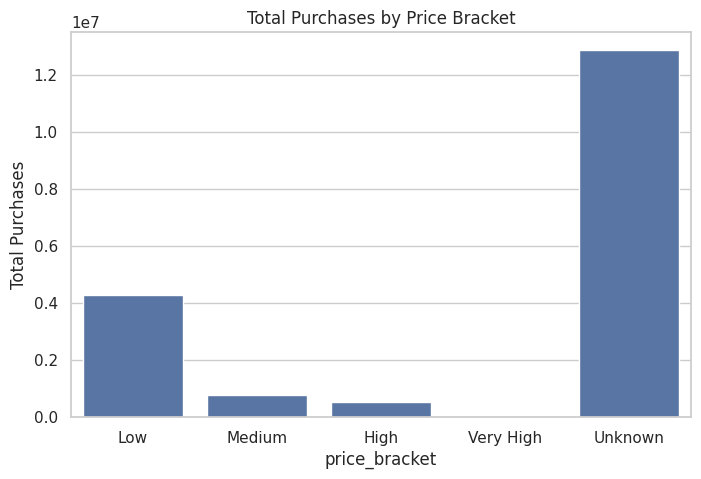

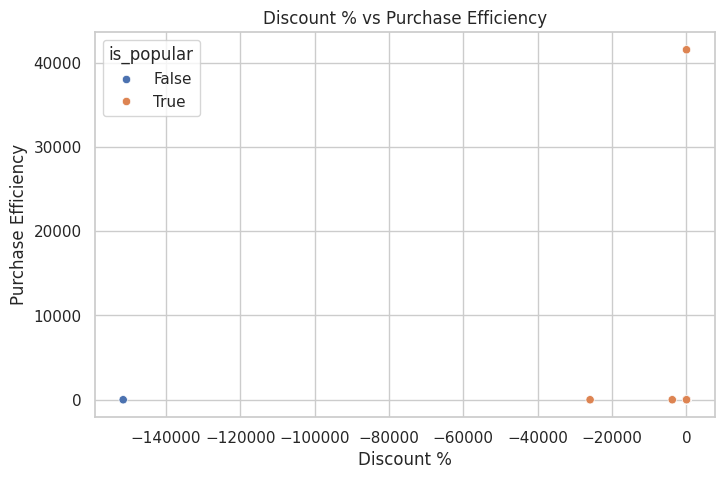

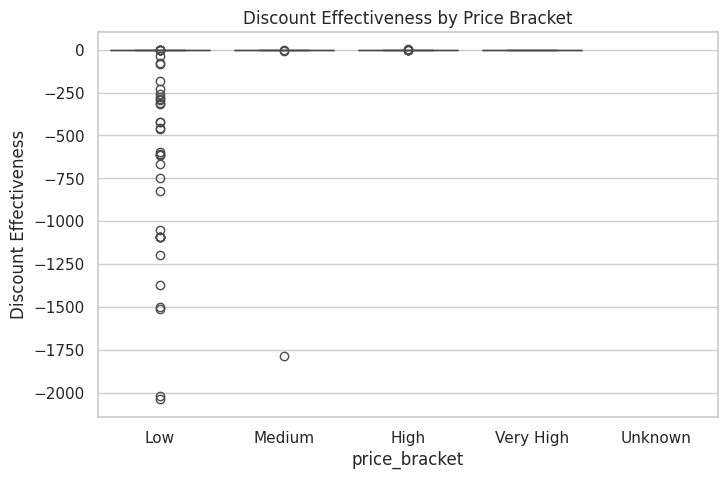


--- Key Visuals for Metrics ---



In [30]:
summary, segment, popularity = eda_df(final_df)

### Legacy

In [31]:
# sns.histplot(df['rating_numeric'].dropna(), bins=20)
# plt.title('Distribution of Ratings')
# plt.show()

In [32]:
# sns.histplot(df['bought_in_last_month_clean'].dropna(), bins=20)
# plt.title('Distribution of Purchases in Last Month')
# plt.show()

In [33]:
# sns.scatterplot(
#     data=df,
#     x='rating_numeric',
#     y='bought_in_last_month_clean'
# )
# plt.title('Rating vs Purchases in Last Month')
# plt.show()

In [34]:
# # Scatter plot: listed price vs discounted price
# sns.scatterplot(
#     data=df,
#     x='listed_price_clean',
#     y='current/discounted_price'
# )
# plt.title('Listed Price vs Discounted Price')
# plt.show()

In [35]:
# for col in ['rating_numeric', 'number_of_reviews', 'bought_in_last_month_clean']:
#     sns.histplot(df[col].dropna(), bins=20)
#     plt.title(f'Distribution of {col}')
#     plt.show()

## EDA on Derivied Metrics

In [36]:
def eda_derived_metrics(df, clip_99=True):
  sns.set(style='whitegrid')

  #Absolute Discount
  plt.figure(figsize=(8,5))
  sns.histplot(df['discount_amount'].dropna(), bins=30)
  plt.title('Distribution of Discount Amount')
  plt.xlabel('Discount Amount ($)')
  plt.show()

  # Discount percentage
  plt.figure(figsize=(8,5))
  sns.histplot(df[df['discount_amount'] > 0]['discount_amount'], bins=30)
  plt.yscale('log')
  plt.title('Distribution of Discount Amount (Non-zero)')
  plt.show()

  # Products per price bracket
  plt.figure(figsize=(8,5))
  sns.countplot(x='price_bracket', data=df)
  plt.title('Number of Products per Price Bracket')
  plt.show()

  #Average Purchases by price bracket
  plt.figure(figsize=(8,5))
  sns.barplot(x='price_bracket', y='bought_in_last_month_clean', data=df)
  plt.title('Average Purchases by Price Bracket')
  plt.show()

  #popularity metrics
  plt.figure(figsize=(8,5))
  sns.countplot(x='is_popular', data=df)
  plt.title('Number of Popular vs Less Popular Products')
  plt.show()

  #Purcheases in the Last month
  plt.figure(figsize=(8,5))
  sns.histplot(df[df['bought_in_last_month_clean']>0]['bought_in_last_month_clean'], bins=30)
  plt.xscale('log')
  plt.title('Purchases in Last Month (Log Scale)')
  plt.show()

  #Listed Price Distrbution
  plt.figure(figsize=(8,5))
  sns.histplot(df[df['listed_price_clean']>0]['listed_price_clean'], bins=30)
  plt.xscale('log')
  plt.title('Listed Price Distribution (Log Scale)')
  plt.show()

  #Purchases in the Last Month
  if clip_99:
    p99 = df['bought_in_last_month_clean'].quantile(0.99)
    plt.figure(figsize=(8,5))
    sns.histplot(df['bought_in_last_month_clean'].clip(upper=p99), bins=30)
    plt.title('Purchases in Last Month (Clipped at 99th percentile)')
    plt.show()

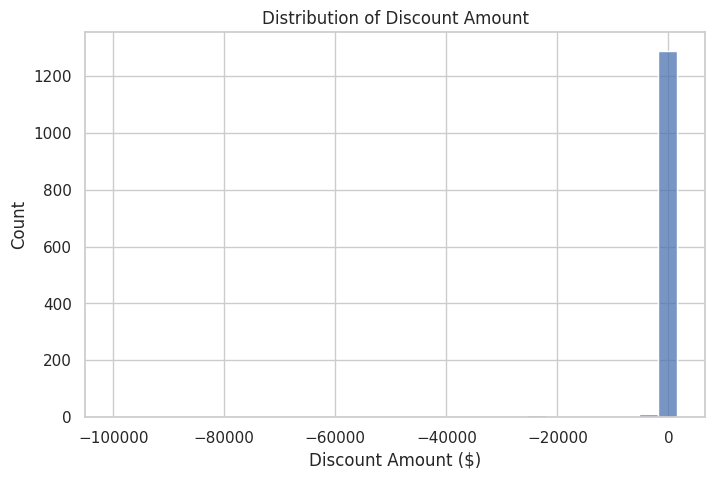

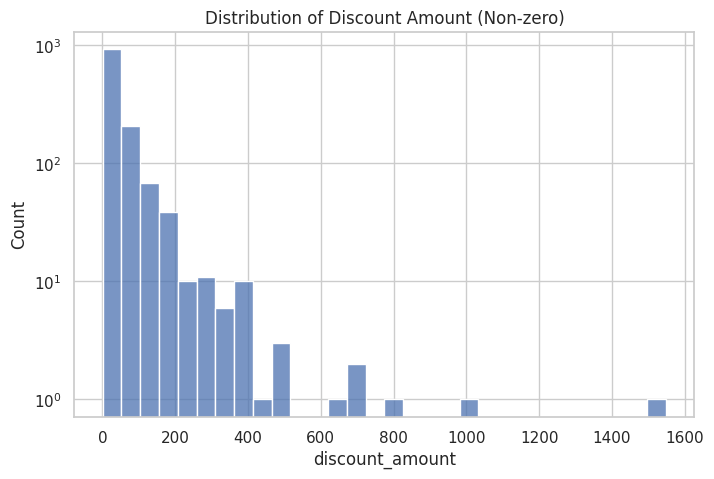

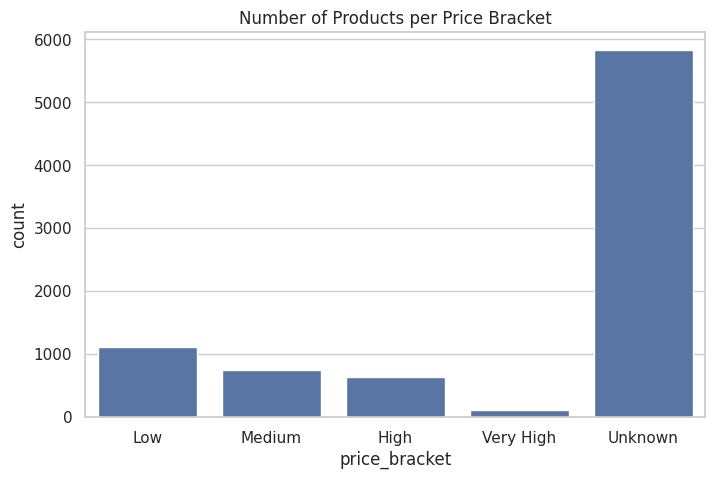

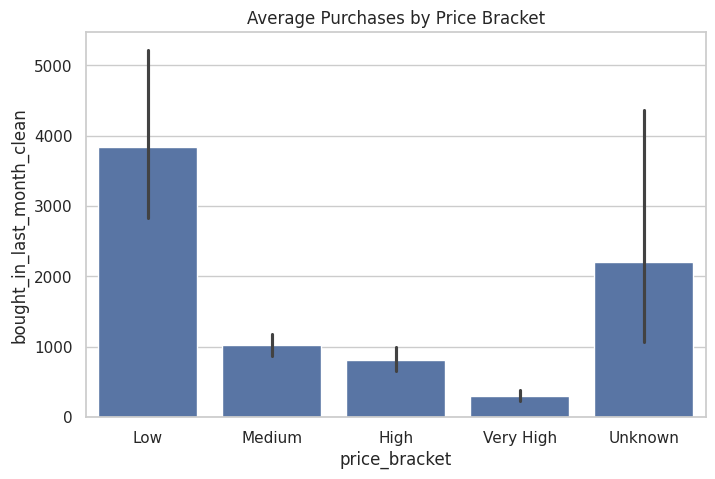

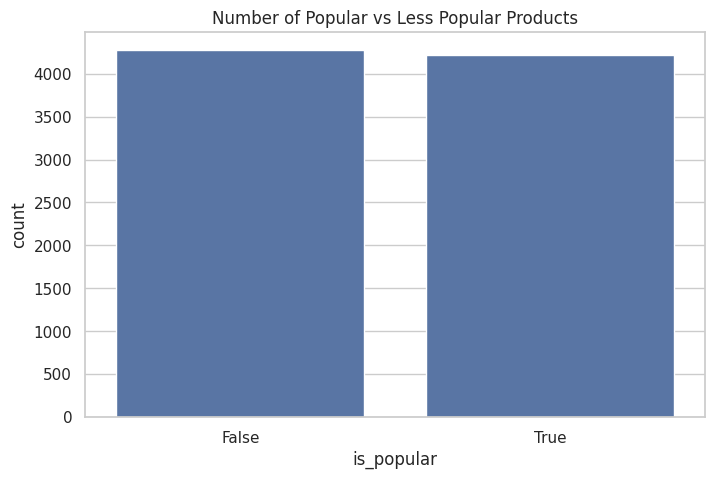

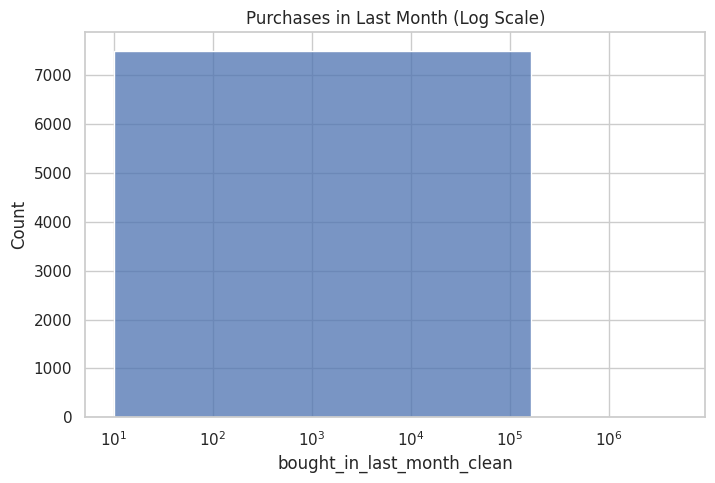

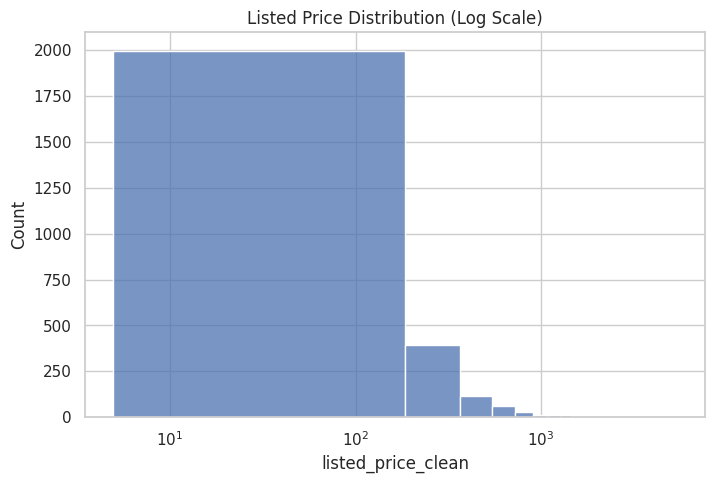

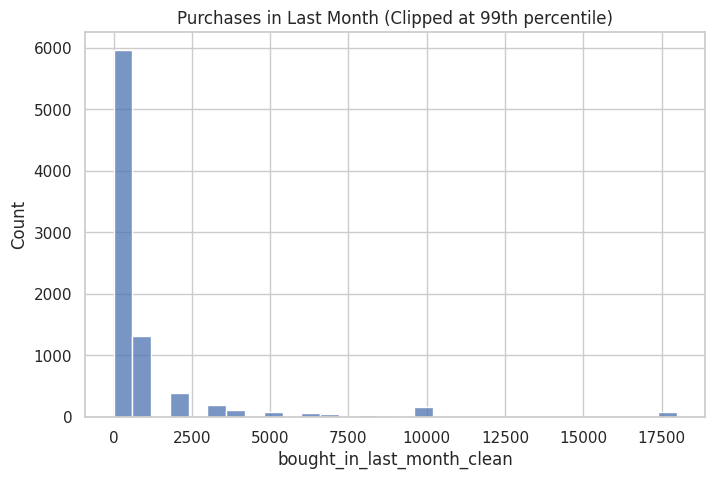

In [37]:
eda_derived_metrics(final_df, clip_99=True)

In [38]:
# #Absolute Discount
# sns.histplot(df['discount_amount'].dropna(), bins=30)
# plt.title('Distribution of Discount Amount')
# plt.xlabel('Discount Amount ($)')
# plt.show()

In [39]:
# # Discount percentage
# sns.histplot(df[df['discount_amount'] > 0]['discount_amount'], bins=30)
# plt.yscale('log')
# plt.title('Distribution of Discount Amount (Non-zero)')
# plt.show()

In [40]:
# # Products per price bracket
# sns.countplot(x='price_bracket', data=df)
# plt.title('Number of Products per Price Bracket')
# plt.show()

In [41]:
# #Average Purchases by price bracket
# sns.barplot(x='price_bracket', y='bought_in_last_month_clean', data=df)
# plt.title('Average Purchases by Price Bracket')
# plt.show()

In [42]:
# #popularity metrics
# sns.countplot(x='is_popular', data=df)
# plt.title('Number of Popular vs Less Popular Products')
# plt.show()

In [43]:
# sns.histplot(df[df['bought_in_last_month_clean']>0]['bought_in_last_month_clean'], bins=30)
# plt.xscale('log')
# plt.title('Purchases in Last Month (Log Scale)')
# plt.show()

In [44]:
# sns.histplot(df[df['listed_price_clean']>0]['listed_price_clean'], bins=30)
# plt.xscale('log')
# plt.title('Listed Price Distribution (Log Scale)')
# plt.show()

In [45]:
# p99 = df['bought_in_last_month_clean'].quantile(0.99)
# sns.histplot(df['bought_in_last_month_clean'].clip(upper=p99), bins=30)
# plt.title('Purchases in Last Month (Clipped at 99th percentile)')
# plt.show()

# Modeling

In [46]:
def modeling_metrics(df, features, target='bought_in_last_month_clean', log_transform=True, plot=True):
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LinearRegression
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, r2_score

  X = df[features].fillna(0)
  y = df[target].fillna(0)

  if log_transform:
      y_trans = np.log1p(y)
  else:
      y_trans = y.copy()

  # Train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

  results = {}

  # Linear Regression
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  y_pred_lr = lr.predict(X_test)
  results['LinearRegression'] = {
      'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
      'r2': r2_score(y_test, y_pred_lr),
      'coefficients': pd.Series(lr.coef_, index=X_train.columns)
  }

  # Random Forest
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_test)
  results['RandomForest'] = {
      'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
      'r2': r2_score(y_test, y_pred_rf),
      'feature_importances': pd.Series(rf.feature_importances_, index=X_train.columns)
  }

  if plot:
      plt.figure(figsize=(6,6))
      plt.scatter(np.expm1(y_test) if log_transform else y_test,
                  np.expm1(y_pred_lr) if log_transform else y_pred_lr,
                  alpha=0.5)
      plt.xlabel('Actual Purchases')
      plt.ylabel('Predicted Purchases (Linear Regression)')
      plt.title('Predicted vs Actual Purchases')
      plt.show()

  return results

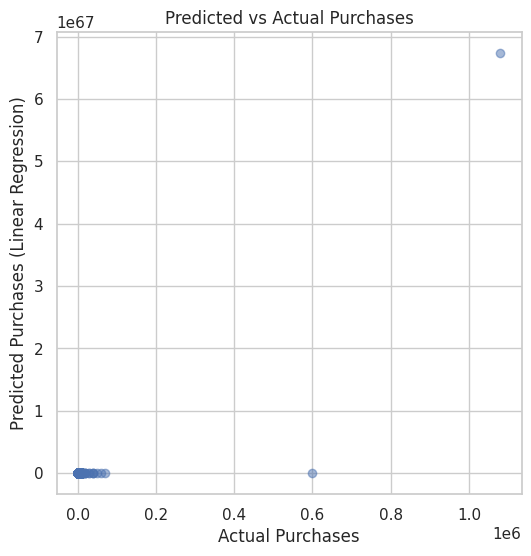

,0
rating_numeric,3.249973e-05
number_of_reviews,9.304731e-06
bought_in_last_month_clean,9.999258e-01
listed_price_clean,3.039736e-06
price_on_variant_clean,8.075438e-06
current/discounted_price,7.526629e-06
discount_amount,5.922585e-07
discount_percentage,3.190615e-07
purchase_efficiency,1.285863e-05


In [47]:
features = ['rating_numeric', 'number_of_reviews', 'bought_in_last_month_clean',
            'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price',
            'discount_amount', 'discount_percentage', 'purchase_efficiency']

results = modeling_metrics(final_df, features)
results['LinearRegression']['coefficients']
results['RandomForest']['feature_importances']

## Data Prep

In [23]:
# # data prep
# features = [
#     'rating_numeric', 'number_of_reviews', 'listed_price_clean', 'price_on_variant_clean', 'current/discounted_price',
#     'discount_amount', 'discount_percentage', 'purchase_efficiency'
# ]
# X = final_df[features]
# y = final_df['bought_in_last_month_clean']

In [24]:
# X = X.fillna(0)
# y = y.fillna(0)
# y_log = np.log1p(y)

In [25]:
# final_df['purchase_efficiency'].fillna(0, inplace=True)
# final_df.replace([np.inf, -np.inf], 0, inplace=True)

/tmp/ipython-input-3588011071.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['purchase_efficiency'].fillna(0, inplace=True)


## Train/Test Split

In [26]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [27]:
# print(np.isinf(X).sum())

rating_numeric              0
number_of_reviews           0
listed_price_clean          0
price_on_variant_clean      0
current/discounted_price    0
discount_amount             0
discount_percentage         0
purchase_efficiency         0
dtype: int64


In [28]:
# print((X.abs() > 1e10).sum())

rating_numeric              0
number_of_reviews           0
listed_price_clean          0
price_on_variant_clean      0
current/discounted_price    0
discount_amount             0
discount_percentage         0
purchase_efficiency         0
dtype: int64


## Linerar Regression

In [29]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred))) # model performance
# print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 5.701818024081302
R2 Score: -4.883642349707206


In [30]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(X_train, y_train)

# # Coefficients
# feature_importance = pd.Series(model.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
# print(feature_importance)

rating_numeric              1.307126
purchase_efficiency         0.005428
current/discounted_price   -0.000522
listed_price_clean         -0.000424
number_of_reviews          -0.000084
discount_amount             0.000076
discount_percentage        -0.000041
price_on_variant_clean      0.000002
dtype: float64


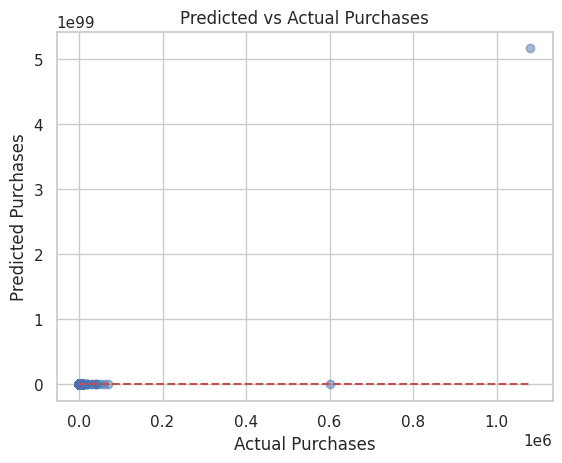

In [33]:
# #visualization
# plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.5)
# plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')  # line y=x
# plt.xlabel('Actual Purchases')
# plt.ylabel('Predicted Purchases')
# plt.title('Predicted vs Actual Purchases')
# plt.show()

## Random Forest Regressor

In [34]:
# from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# print(importances)

current/discounted_price    0.237120
number_of_reviews           0.216965
purchase_efficiency         0.212326
price_on_variant_clean      0.182343
rating_numeric              0.119464
listed_price_clean          0.020241
discount_percentage         0.005842
discount_amount             0.005699
dtype: float64


##Visualizations for Modeling

<Figure size 1000x600 with 0 Axes>

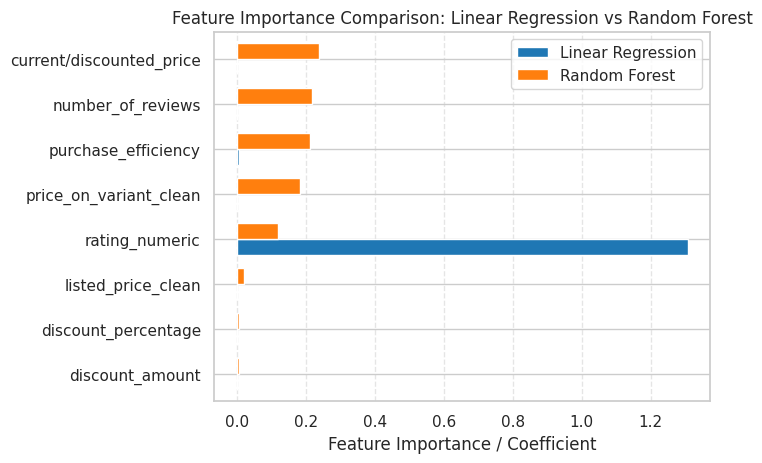

In [37]:
# Linear Regression Coefficients
lr_coefs = pd.Series({
    'rating_numeric': 1.307126,
    'purchase_efficiency': 0.005428,
    'current/discounted_price': -0.000522,
    'listed_price_clean': -0.000424,
    'number_of_reviews': -0.000084,
    'discount_amount': 0.000076,
    'discount_percentage': -0.000041,
    'price_on_variant_clean': 0.000002
})

# Random Forest Importances
rf_importances = pd.Series({
    'current/discounted_price': 0.237120,
    'number_of_reviews': 0.216965,
    'purchase_efficiency': 0.212326,
    'price_on_variant_clean': 0.182343,
    'rating_numeric': 0.119464,
    'listed_price_clean': 0.020241,
    'discount_percentage': 0.005842,
    'discount_amount': 0.005699
})

# Combine into one DataFrame
df_plot = pd.DataFrame({
    'Linear Regression': lr_coefs,
    'Random Forest': rf_importances
}).sort_values(by='Random Forest', ascending=True)  # sort by RF for easier viewing

# Plot
plt.figure(figsize=(10,6))
df_plot.plot(kind='barh', width=0.7, color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Feature Importance / Coefficient')
plt.title('Feature Importance Comparison: Linear Regression vs Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


#Business Insights
